In [233]:
#sys.path.append("C:\Program Files\Autodesk\InfoWater Pro\Bin\Python")
import arcpy
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import csv

from infowater.output.manager import Manager as OutMan

# Define User Inputs:
project_name = "Purpletown"
scenario1 = "Base"
scenario2 = "Break"

# Get Outputs
aprx = arcpy.mp.ArcGISProject("CURRENT")
project_path = Path(aprx.filePath).parent
out1_path = str(project_path) + "/" + project_name + ".OUT/SCENARIO/" + scenario1 + "/HYDQUA.OUT"
out2_path = str(project_path) + "/" + project_name + ".OUT/SCENARIO/" + scenario2 + "/HYDQUA.OUT"
out1 = OutMan(out1_path)
out2 = OutMan(out2_path)

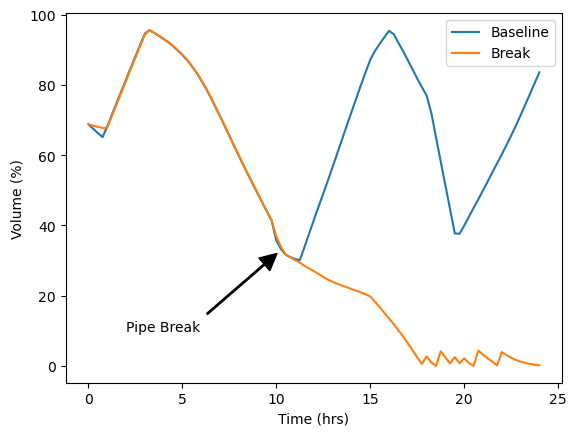

In [234]:
# Generate custom graph from multiple Scenarios
times = out1.get_time_list()
tank_vol_1 = out1.get_time_data("Tank","T5004","% Volume")
tank_vol_2 = out2.get_time_data("Tank","T5004","% Volume")

%matplotlib inline
plt.plot(times, tank_vol_1)
plt.plot(times, tank_vol_2)
plt.xlabel("Time (hrs)")
plt.ylabel("Volume (%)")
plt.legend(["Baseline","Break"])
plt.annotate('Pipe Break', xy=(10.25, 33), xytext=(2, 10),
             arrowprops=dict(facecolor='black', width=1, shrink=0.05))

plt.show()

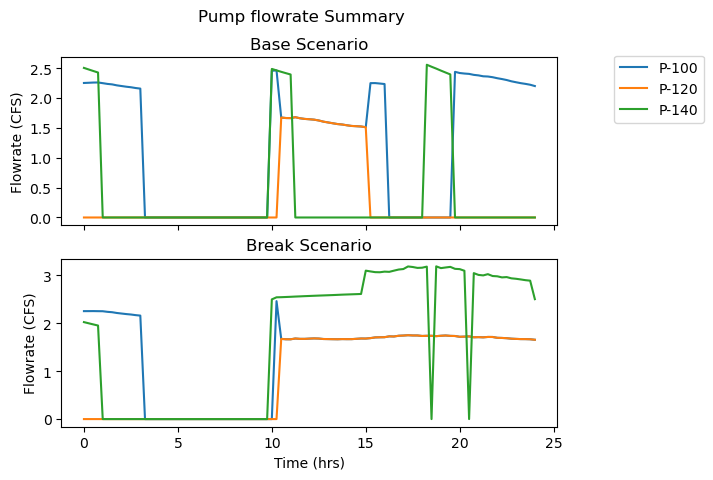

In [235]:
# Generate view of multiple objects in one graph
fig2, axs = plt.subplots(2)
fig2.suptitle('Pump flowrate Summary')
  
for i in out1.get_element_list("pump"):
    axs[0].plot(times, out1.get_time_data("Pump",i,"Flow"))
    axs[1].plot(times, out2.get_time_data("Pump",i,"Flow"))
    
axs[0].set_title('Base Scenario')
axs[1].set_title('Break Scenario')
axs[0].legend(out1.get_element_list("pump"),bbox_to_anchor=(1.1,1.05))

for ax in axs.flat:
    ax.set(xlabel='Time (hrs)', ylabel='Flowrate (CFS)')
    ax.label_outer()


In [236]:
# Summarize Pump average flows
df = pd.DataFrame(
{
    "pump": out1.get_element_list("pump"),
    "Base Avg Flow": out1.get_range_data("pump", "Flow", "Avg"),
    "Break Avg Flow": out2.get_range_data("pump", "Flow", "Avg"),
})
df

,pump,Base Avg Flow,Break Avg Flow
0,P-100,1.186781,1.286413
1,P-120,0.313772,0.963527
2,P-140,0.380659,1.712585


In [237]:
p1min = out1.get_range_data("Junction", "Pressure", "min")
p2min = out2.get_range_data("Junction", "Pressure", "min")
junctions = out1.get_element_list("Junction")

#Get list of junctions with minimum pressure below 20 psi and also a notable difference from baseline simulation.
selection = [i for i, (x, y) in enumerate(zip(p1min, p2min)) if abs(x-y)>10 and y<20]

p1avg = out1.get_range_data("Junction", "Pressure", "avg")
dmd1avg = out1.get_range_data("Junction", "Demand", "avg")

df = pd.DataFrame(
{
    "Impacted Junctions": [junctions[i] for i in selection],
    "Base Avg Demand (gpm)": [dmd1avg[i]*448.8 for i in selection],
    "Base Avg Pressure (psi)": [p1avg[i]*0.433 for i in selection],
    "Base min Pressure (psi)": [p1min[i]*0.433 for i in selection],
    "Break min Pressure (psi)": [p2min[i]*0.433 for i in selection],
})

df.sort_values(by='Base Avg Demand (gpm)',ascending=False)

,Impacted Junctions,Base Avg Demand (gpm),Base Avg Pressure (psi),Base min Pressure (psi),Break min Pressure (psi)
192,J96,2.132390,61.829441,61.760860,-44.054357
69,J252,2.124921,133.361701,128.509505,-75.282107
67,J248,1.970194,137.126903,132.277774,-71.510463
20,J1394,1.928933,127.354394,122.105194,-81.751128
54,J222,1.887673,97.045900,92.200979,-111.588942
...,...,...,...,...,...
11,8472,0.144412,67.867927,63.157109,-140.729863
50,J214,0.144412,146.250441,141.397493,-62.396029
9,8468,0.134097,43.661862,38.906784,-164.959046
13,8484,0.104529,73.669774,73.549631,-32.242752


In [ ]:
#Export Table report to Excel

Junction_report = str(project_path) + "/" + "Junction_report.xlsx"

df.to_excel(Junction_report)

In [ ]:
# Export full timeseries to CSV for selected objects
Junction_timeseries = str(project_path) + "/" + "Junction_timeseries.csv"
selected_junctions = [junctions[i] for i in selection]

with open(Junction_timeseries, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['ID', 'Time (hrs)', 'Demand (gpm)', 'Pressure (psi)'])
    for id in selected_junctions:
        demand = out2.get_time_data("junction", id, "demand")
        pressure = out2.get_time_data("junction", id, "pressure")
        for i in range(len(times)):
            writer.writerow([id, str(times[i]), str(demand[i]), str(pressure[i])])

In [ ]:
# Quick Tips:

help(OutMan) # Get in-line help
help(out1.get_range_data) # Get help for individual functions

# Get detailed output of output metadata for lists of types, outputs, indices, etc.
import json
metadata = out1.get_metadata() 
print(json.dumps(vars(metadata), indent=4))